In [100]:
import pandas as pd
import statsmodels.api as sm 
from matplotlib import pyplot as plt
import numpy as np
from patsy import dmatrices

Read in the Product Level Data

In [101]:
transactions = pd.read_excel("C:/Users/morey/OneDrive/Python_Scripts/SnackChain.xlsx", sheet_name = "transactions")

products = pd.read_excel("C:/Users/morey/OneDrive/Python_Scripts/SnackChain.xlsx", sheet_name = "products")

Exploratory Data Analysis 

In [102]:
transactions.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,0
2,2009-01-14,367,1111009507,14,14,14,19.32,1.38,1.38,0,0,0
3,2009-01-14,367,1111035398,4,3,3,14.00,3.50,4.49,0,0,1
4,2009-01-14,367,1111038078,3,3,3,7.50,2.50,2.50,0,0,0


In [103]:
products.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111035398,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [104]:
#Grabbing min and max date for my knowledge
transactions["WEEK_END_DATE"].max(), transactions["WEEK_END_DATE"].min()

(Timestamp('2012-01-04 00:00:00'), Timestamp('2009-01-14 00:00:00'))

In [105]:
#Join the 2 data frames together to get descripter columns for the products

df = pd.merge(transactions,products, on="UPC")

Data Cleaning & Inspection

In [106]:
#Removing these products per the professor. 
df = df[df["CATEGORY"] != "ORAL HYGIENE PRODUCTS"]

In [107]:
df.count()

WEEK_END_DATE    408421
STORE_NUM        408421
UPC              408421
UNITS            408421
VISITS           408421
HHS              408421
SPEND            408421
PRICE            408411
BASE_PRICE       408248
FEATURE          408421
DISPLAY          408421
TPR_ONLY         408421
DESCRIPTION      408421
MANUFACTURER     408421
CATEGORY         408421
SUB_CATEGORY     408421
PRODUCT_SIZE     408421
dtype: int64

In [108]:
df.isna().sum()

WEEK_END_DATE      0
STORE_NUM          0
UPC                0
UNITS              0
VISITS             0
HHS                0
SPEND              0
PRICE             10
BASE_PRICE       173
FEATURE            0
DISPLAY            0
TPR_ONLY           0
DESCRIPTION        0
MANUFACTURER       0
CATEGORY           0
SUB_CATEGORY       0
PRODUCT_SIZE       0
dtype: int64

In [109]:
df = df.dropna()

In [110]:
df.isnull().count()

WEEK_END_DATE    408238
STORE_NUM        408238
UPC              408238
UNITS            408238
VISITS           408238
HHS              408238
SPEND            408238
PRICE            408238
BASE_PRICE       408238
FEATURE          408238
DISPLAY          408238
TPR_ONLY         408238
DESCRIPTION      408238
MANUFACTURER     408238
CATEGORY         408238
SUB_CATEGORY     408238
PRODUCT_SIZE     408238
dtype: int64

Goal: Find the products which are most price sensitive and most insensitive using Linear Regression

Check distribution of the target variable: Units

In [111]:
df["UNITS"].describe()

count    408238.000000
mean         23.931533
std          32.576693
min           1.000000
25%           7.000000
50%          15.000000
75%          29.000000
max        1800.000000
Name: UNITS, dtype: float64

In [112]:
#Another way of looking at the distribution
#We can use a log transformation here to try to normalize this dsitribution some 
#This is count data as well so it will be the same as a Poisson Regression commonly used on count data
df.groupby("UNITS")["UNITS"].count()

UNITS
1       15535
2       16721
3       17223
4       16767
5       16604
        ...  
1017        1
1054        1
1136        1
1179        1
1800        1
Name: UNITS, Length: 567, dtype: int64

(array([5.52344586e-03, 3.04321711e-05, 3.56744019e-06, 7.89738667e-07,
        2.72323678e-07, 9.53132874e-08, 2.72323678e-08, 0.00000000e+00,
        0.00000000e+00, 1.36161839e-08]),
 array([1.0000e+00, 1.8090e+02, 3.6080e+02, 5.4070e+02, 7.2060e+02,
        9.0050e+02, 1.0804e+03, 1.2603e+03, 1.4402e+03, 1.6201e+03,
        1.8000e+03]),
 <BarContainer object of 10 artists>)

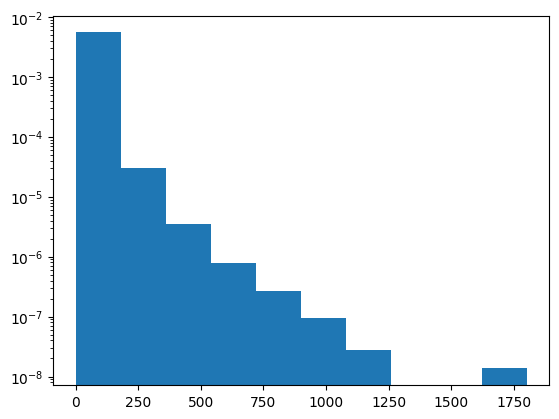

In [113]:

plt.hist(df["UNITS"], density=True, log = True)

Create Empty Arrays to add Model coeff & product names to after

In [114]:
upcs = df["UPC"].unique()
product_names_ids = df[["UPC","DESCRIPTION"]]

In [115]:
upcs

array([ 1111009477,  1111009497,  1111009507,  1111085319,  1111085345,
        1111085350,  1111087395,  1111087396,  1111087398,  1600027527,
        1600027528,  1600027564,  2840004768,  3000006340,  3000006560,
        3000006610,  3800031829,  3800031838,  3800039118,  7027316204,
        7027316404,  7192100336,  7192100337,  7192100339,  7218063052,
        7218063979,  7218063983,  7797508004,  7797508006,  2840002333,
        2840004770,  7027312504,  7110410455,  7110410470,  7110410471,
        7797502248, 88491201426, 88491201427, 88491212971,  2066200530,
        2066200531,  2066200532], dtype=int64)

In [116]:
product_names_ids = product_names_ids.drop_duplicates()

In [117]:
product_names_ids

,UPC,DESCRIPTION
0,1111009477,PL MINI TWIST PRETZELS
11938,1111009497,PL PRETZEL STICKS
23898,1111009507,PL TWIST PRETZELS
66754,1111085319,PL HONEY NUT TOASTD OATS
78713,1111085345,PL RAISIN BRAN
90693,1111085350,PL BT SZ FRSTD SHRD WHT
102656,1111087395,PL SR CRUST SUPRM PIZZA
114304,1111087396,PL SR CRUST 3 MEAT PIZZA
125875,1111087398,PL SR CRUST PEPPRN PIZZA
137711,1600027527,GM HONEY NUT CHEERIOS


This is good for the whole population but we want one for each product!

In [118]:
df_test =  df[df["UPC"] == 7218063979]

In [119]:
y = np.log(df_test["UNITS"])
x = df_test["PRICE"]

In [120]:
mod = sm.OLS(y,x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  UNITS   R-squared (uncentered):                   0.548
Model:                            OLS   Adj. R-squared (uncentered):              0.548
Method:                 Least Squares   F-statistic:                          1.183e+04
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                        0.00
Time:                        14:41:15   Log-Likelihood:                         -15457.
No. Observations:                9738   AIC:                                  3.092e+04
Df Residuals:                    9737   BIC:                                  3.092e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Here we run the linear model for each product (UPC)

In [121]:
coeffs = []

for i in range(1,len(upcs)):
    #subset the original dataframe
    df_inbetween = df[df["UPC"] == upcs[i]]
    #set model variables
    y = np.log(df_inbetween["UNITS"])
    x = df_inbetween["PRICE"]
    #run model
    mod = sm.OLS(y,x)
    #append results to array
    res = mod.fit()
    coeffs.append(res.params.sum())


Create a Dataframe & Products To Show Results

In [122]:
coeffs = np.array(coeffs)

In [123]:
final_df = pd.DataFrame(data = [upcs,coeffs]).T
final_df.columns = ['UPC','Coefficients']


In [124]:
final_df = pd.merge(final_df,product_names_ids, on = ["UPC"])

In [125]:
final_df = final_df.sort_values(by = 'Coefficients')

Products with the Lowest Coefficients

In [126]:
final_df.head()
#Interpretation help: For every 1 cent increase in price there is a ~19.6% increase in units sold. 

,UPC,Coefficients,DESCRIPTION
25,7.218064e+09,0.196048,FRSC PEPPERONI PIZZA
40,2.066201e+09,0.203694,NWMN OWN 4 CHEESE PIZZA
24,7.218063e+09,0.204517,FRSC BRCK OVN ITL PEP PZ
23,7.192100e+09,0.221786,DIGRN PEPP PIZZA
38,8.849121e+10,0.248403,POST FRUITY PEBBLES


Above are the top 5 products which move the least in Quantity sales when the price is changed. These products must be watched closely as they are price elastic, and price is a huge factor to the consumers purchaising this product.